#### Import libraries

In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

#### Dataset

In [24]:
df = pd.read_csv('base_data/adultdataset.csv', na_values='NaN', skipinitialspace=True)

columns_to_impute = ['workclass', 'occupation', 'native-country']
for col in columns_to_impute:
    mode_val = df[col].mode()[0]
    df[col] = df[col].fillna(mode_val)

#### Encoding

In [25]:
education_order = [
    'Preschool', '1st-4th', '5th-6th', '7th-8th', '9th',
    '10th', '11th', '12th', 'HS-grad',
    'Some-college', 'Assoc-voc', 'Assoc-acdm',
    'Bachelors', 'Masters', 'Doctorate'
]

df['education'] = pd.Categorical(df['education'], categories=education_order, ordered=True)
df['education'] = df['education'].cat.codes

one_hot_cols = [
    'workclass', 'marital-status', 'occupation', 'relationship',
    'race', 'sex', 'native-country'
]

df = pd.get_dummies(df, columns=one_hot_cols, drop_first=True)

df['income'] = df['income'].map({'<=50K': 0, '>50K': 1})

#### Prepare data

In [26]:
X = df.drop(columns='income')
y = df['income']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

rus = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = rus.fit_resample(X_train, y_train)

# Use cases

## Governmental policy making

### Random Forest with undersampling, optimized for recall

Policymakers can use insights from income predictions to design more targeted interventions aimed at reducing income inequality. For instance, understanding how education or housing factors contribute to higher income levels can inform decisions about funding educational programs, for example helping women in rural areas, which are often at a disadvantage in terms of opportunities compared to their urban counterparts, get access to better education.

For this problem we need to focus on two metrics:
1. Recall - we need to identify as many eligible individuals as possible to ensure no one is left behind, even if that means some false positives.
2. F1 Score - we want a balance between identifying eligible individuals and minimizing false positives, ensuring that resources are allocated efficiently.

For this reason we'll use the **Random Forest Classifier** with the hyperparameters tuned for recall, using **undersampling**, as it provides a good balance between identifying eligible individuals and minimizing false positives.

In [27]:
print("Training Random Forest for governmental policy making (optimized for recall)")

# tuned hyperparameters
rf_model = RandomForestClassifier(
    random_state=42, 
    max_depth=10, 
    min_samples_leaf=2, 
    min_samples_split=5, 
    n_estimators=100
)

rf_model.fit(X_train_under, y_train_under)

y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# metrics
print("\nGovernmental Policy Making - Model Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_rf):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_rf):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba_rf):.4f}")

Training Random Forest for governmental policy making (optimized for recall)

Governmental Policy Making - Model Performance:
Accuracy: 0.7968
Precision: 0.5462
Recall: 0.8918
F1 Score: 0.6775
ROC AUC: 0.9137


### Visualizations

#### Confusion Matrix

<Figure size 1000x800 with 0 Axes>

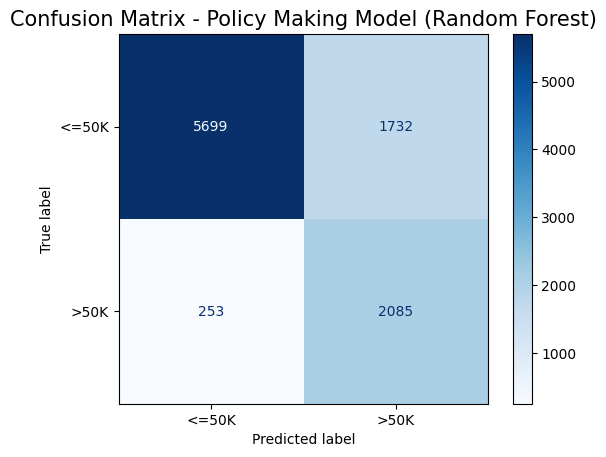

In [28]:
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["<=50K", ">50K"])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - Policy Making Model (Random Forest)', fontsize=15)
plt.savefig('figs/policy_making_cm.png', dpi=300, bbox_inches='tight')
plt.show()

## Bank loan approval

### XGBoost with raw data, optimized for precision

In [29]:
print("Training XGBoost for Bank Loan Approval (Optimized for Precision)")

xgb_model = XGBClassifier(
    eval_metric='logloss', 
    random_state=42, 
    colsample_bytree=0.8, 
    learning_rate=0.01, 
    max_depth=3, 
    n_estimators=100, 
    subsample=1.0
)

xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

print("\nBank Loan Approval - Model Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_xgb):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_xgb):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_xgb):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba_xgb):.4f}")

Training XGBoost for Bank Loan Approval (Optimized for Precision)

Bank Loan Approval - Model Performance:
Accuracy: 0.8184
Precision: 0.9845
Recall: 0.2451
F1 Score: 0.3925
ROC AUC: 0.9008


### Visualizations

<Figure size 1000x800 with 0 Axes>

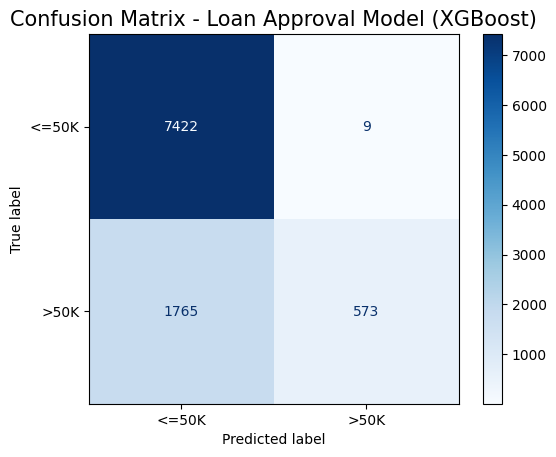

In [30]:
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["<=50K", ">50K"])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - Loan Approval Model (XGBoost)', fontsize=15)
plt.savefig('figs/loan_approval_cm.png', dpi=300, bbox_inches='tight')
plt.show()